# XGBoost vs Random Forest

## Importing the libraries

In [4]:
#!pip install xgboost

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [20]:
# Load your data
df = pd.read_excel("All_Cleaned_Summary.xlsx")
df.head()

,Tailing Type,USGS Class.,Top Depth (m),Bottom Depth (m),Sigma'v (MPa),qt (MPa),fs (MPa),FR (%),PP (Mpa) - CPT,PP (MPa) - hydrostatic,Ic,State Parameter (Robertson 2021),"Qtc,cs",Fine content (%),Moisture content (%),Liquified? (Y/N)
0,Nickel,GP-SP,NaN,NaN,0.014939,4.632021,0.0089,0.192141,0.020104,0.015936,1.104446,-0.124985,119.044871,38.0,NaN,N
1,Nickel,GP-SP,NaN,NaN,0.015168,4.122962,0.0088,0.213439,0.019810,0.016182,1.176848,-0.107070,105.056722,38.0,NaN,N
2,Nickel,GP-SP,NaN,NaN,0.015398,3.844962,0.0090,0.234073,0.019810,0.016427,1.228733,-0.095890,97.173171,38.0,NaN,N
3,Nickel,GP-SP,NaN,NaN,0.015628,3.659197,0.0074,0.202230,0.020987,0.016672,1.224832,-0.087652,91.744952,38.0,NaN,N
4,Nickel,GP-SP,NaN,NaN,0.015858,3.338374,0.0043,0.128805,0.021870,0.016917,1.198538,-0.073312,83.009343,38.0,NaN,N


In [36]:
# Drop low-utility or high-missing-value columns
df_clean = df.drop(columns=['PP (Mpa) - CPT', 'Moisture content (%)'])

# Drop rows with missing essential values
df_clean = df_clean.dropna(subset=['Liquified? (Y/N)', 'fs (MPa)', 'FR (%)', 'Ic'])

# Encode target variable
df_clean['Liquified'] = df_clean['Liquified? (Y/N)'].map({'Y': 1, 'N': 0})

# Fill missing values in categorical columns
df_clean['USGS Class.'] = df_clean['USGS Class.'].fillna("Unknown")
df_clean['Tailing Type'] = df_clean['Tailing Type'].fillna("Unknown")

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_clean, columns=['USGS Class.', 'Tailing Type'])

# Prepare features and target
X = df_encoded.drop(columns=['Liquified? (Y/N)', 'Liquified'])
y = df_encoded['Liquified']

## Splitting the dataset into the Training set and Test set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building XGBoost and Random Forest Classifiers

In [42]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_rf = RandomForestClassifier(random_state=42)

### Perform Cross Validation

In [45]:
# Evaluate with 5-fold cross-validation using accuracy
xgb_cv = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='accuracy')
rf_cv = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='accuracy')

print(f"XGBoost CV Accuracy: {xgb_cv.mean():.4f} ± {xgb_cv.std():.4f}")
print(f"Random Forest CV Accuracy: {rf_cv.mean():.4f} ± {rf_cv.std():.4f}")

/Volumes/Mac/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Volumes/Mac/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Volumes/Mac/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Volumes/Mac/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

XGBoost CV Accuracy: 0.9986 ± 0.0007
Random Forest CV Accuracy: 0.9999 ± 0.0002


In [47]:
#selected model is Random Forest
model = model_rf
model.fit(X_train, y_train)  # Train on full training data
y_pred = model.predict(X_test)

In [49]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1406
           1       1.00      1.00      1.00      1794

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



## Making the Confusion Matrix

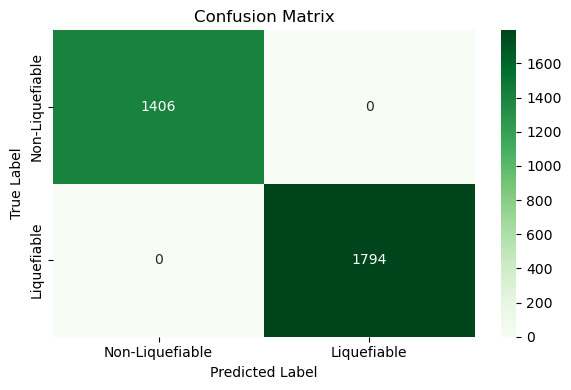

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Liquefiable', 'Liquefiable'],
            yticklabels=['Non-Liquefiable', 'Liquefiable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('reduced_feature.png')
plt.show()

In [53]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

Accuracy Score: 1.00


In [55]:
from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision Score: {precision:.2f}")

Precision Score: 1.00


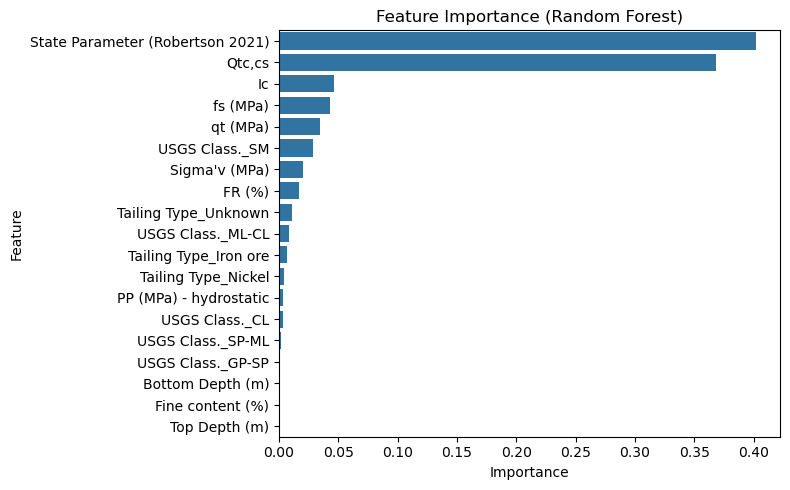

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming model is your trained XGBoost model
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for plotting
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()